# Проект: Анализ поведения пользователей приложения

Цель: Изучить воронку продаж

Задачи:
- Узнать, как пользователи доходят до покупки.
- Исследовать результаты A/A/B-эксперимента по изменению шрифтов в приложении  

Описание данных  
Данные хранятся в файле logs_exp.csv  
Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Шаг 1. Откройте файл с данными и изучите общую информацию**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

In [2]:
data = pd.read_csv(r'D:\Main\Yandex Practicum\Y.Anal\Pivot project 1/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Вывод: в таблице есть пропуски и неверные типы данных. Нужно это исправить. Не удастся заменить: пропуски в колонках имя, год выпуска, жанр, возрастной рейтинг, рейтинги игроков и критиков. Типы данных можно исправить в колонках: год выпуска (на int), оценки пользователей(на float).

**Шаг 2. Подготовьте данные**

Проверим, есть ли полные дубликаты

In [6]:
#list(data['Name'].unique())

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
np.shape(data)

(16715, 11)

Избавимся от пропусков

Nan в рейтингах критиков и игроков нечем заменить. Медиана не подойдет

In [9]:
data['Critic_Score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [10]:
data['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

TBD - to be desided. Значит, рейтинг еще неподсчитан. Заменять на медианное значение не стоит.

In [11]:
data = data[data['User_Score'] != 'tbd']

Преобразуем типы данных

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14291 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             14289 non-null  object 
 1   Platform         14291 non-null  object 
 2   Year_of_Release  14070 non-null  float64
 3   Genre            14289 non-null  object 
 4   NA_sales         14291 non-null  float64
 5   EU_sales         14291 non-null  float64
 6   JP_sales         14291 non-null  float64
 7   Other_sales      14291 non-null  float64
 8   Critic_Score     7055 non-null   float64
 9   User_Score       7590 non-null   object 
 10  Rating           7575 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.3+ MB


Удалим строки с пропусками в дате релиза, чтобы можно было привести весь столбец к целочисленным значениям

In [13]:
data = data.dropna(subset=['Year_of_Release'])

In [14]:
data['Year_of_Release'] = data['Year_of_Release'].astype(int)

Остальные пропуски замением на Unknown

In [15]:
data['Name'] = data['Name'].fillna('Unknown')

In [16]:
data['Genre'] = data['Genre'].fillna('Unknown')

In [17]:
data['Rating'] = data['Rating'].fillna('Unknown')

Тип данных столбца с оценками игроков заменим на float

In [18]:
data['User_Score'] = data['User_Score'].astype(float)

In [19]:
data.isna().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       7143
User_Score         6607
Rating                0
dtype: int64

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14070 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             14070 non-null  object 
 1   Platform         14070 non-null  object 
 2   Year_of_Release  14070 non-null  int32  
 3   Genre            14070 non-null  object 
 4   NA_sales         14070 non-null  float64
 5   EU_sales         14070 non-null  float64
 6   JP_sales         14070 non-null  float64
 7   Other_sales      14070 non-null  float64
 8   Critic_Score     6927 non-null   float64
 9   User_Score       7463 non-null   float64
 10  Rating           14070 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.2+ MB


Добавим столбец суммарных продаж по всем регионам

In [21]:
data['Total_sales'] = data['NA_sales']+data['EU_sales']+data['JP_sales']+data['Other_sales']

In [22]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating,Total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38


Вывод: На этом шаге мы устранили все пропуски, и изменили типы данных на соответствующие. Пропуски в данных могли возникнуть из-за того, что таблица собиралась из различных открытых источников. Некоторые данные могли просто не найти, других данных, например, рейтингов от игроков могло не быть в принципе. Возможно, были совершены ошибки при сопоставлении данных из разных источников. Никогда не исключаем фактор человеческой ошибки или сбоя при переносе/обработке данных.

Изменим регистр названий колонок

In [23]:
data.columns= data.columns.str.lower()

**Шаг 3. Исследовательский анализ данных**

3.1 Посмотрим, сколько игр выпускалось в разные годы

In [24]:
data_grouped_release = data.groupby('year_of_release')['name'].count()

In [25]:
print(data_grouped_release.head())

year_of_release
1980     9
1981    46
1982    36
1983    17
1984    14
Name: name, dtype: int64


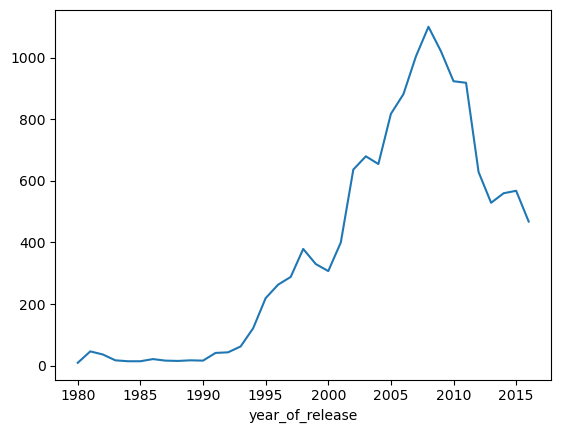

In [26]:
data_grouped_release.plot();

В 80-е 90-е годы каждый год выпускалось примерно одно и то-же количество новых игр. Эти данные, вероятно, нам не слишком неинтересны, но и удалять их незачем.

3.2 Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [27]:
data_grouped_platform = data.groupby('platform')['total_sales'].sum()

In [28]:
data_grouped_platform.sort_values(ascending=False).head(18)

platform
PS2     1171.19
X360     948.74
PS3      921.09
Wii      791.91
PS       714.26
DS       655.36
PS4      314.00
PSP      273.11
GBA      263.70
GB       254.43
3DS      253.24
PC       252.25
NES      251.05
XB       236.38
N64      218.01
SNES     200.04
GC       185.68
XOne     158.77
Name: total_sales, dtype: float64

In [29]:
top_platforms = data_grouped_platform.sort_values(ascending=False).head(18).index.tolist()

In [30]:
data_top_platform_slice = data.query('platform in @top_platforms').pivot_table(index= ['year_of_release', 'platform'],\
                                                                               values='total_sales', aggfunc='sum')

In [31]:
data_top_platform_slice.head(60)

total_sales
year_of_release platform             
1983            NES             10.96
1984            NES             50.08
1985            DS               0.02
                NES             53.44
                PC               0.04
1986            NES             36.41
1987            NES             19.76
1988            GB               1.43
                NES             45.01
                PC               0.03
1989            GB              64.97
                NES              7.85
1990            GB               4.89
                NES             15.73
                SNES            26.15
1991            GB               5.57
                NES              6.11
                SNES            16.22
1992            GB              25.49
                NES              1.98
                PC               3.03
                SNES            32.98
1993            NES              3.61
                SNES            40.02
1994            GB              12.18
                NES              0.11
                PC              12.87
                PS               6.03
                SNES            35.08
1995            GB               3.60
                PC               4.22
                PS              35.96
                SNES            32.20
1996            GB              36.03
                N64             34.10
                PC              10.58
                PS              94.70
                SNES            15.92
1997            GB               6.37
                N64             39.50
                PC              11.27
                PS             136.12
                SNES             0.99
1998            GB              26.90
                N64             49.24
                PC               3.26
                PS             169.49
                SNES             0.22
1999            GB              38.00
                N64             57.87
                PC               2.80
                PS             142.19
                SNES             0.26
2000            GB              19.76
                GBA              0.07
                N64             33.97
                PC               4.66
                PS              86.71
                PS2             34.91
                XB               0.99

Похоже, что каждые 10 лет появляется новая версия платформы, а старая приходит в упадок.

3.3/3.4 Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.

In [32]:
print(data['year_of_release'].unique())

[2006 1985 2008 2009 1996 1989 1984 2005 1999 2007 2010 2013 2004 1990
 1988 2002 2001 2011 1998 2015 2012 2014 1992 1997 1993 1994 1982 2016
 2003 1986 2000 1995 1991 1981 1987 1980 1983]


In [33]:
years = data['year_of_release'].unique()

In [34]:
years = sorted(years, reverse=True)

In [35]:
years_actual = years[0:3]

In [36]:
print(years_actual)

[2016, 2015, 2014]


In [37]:
data_actual = data.query('year_of_release in @years_actual')

In [38]:
data_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Unknown,7.98


3.5 Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [39]:
data_actual_grouped_platform = data_actual.groupby('platform')['total_sales'].sum()

In [40]:
data_actual_grouped_platform.sort_values(ascending=False).head(10)

platform
PS4     288.01
XOne    139.81
3DS      85.38
PS3      66.86
X360     46.86
WiiU     42.58
PC       26.96
PSV      22.09
Wii       2.76
PSP       0.36
Name: total_sales, dtype: float64

Лидеры среди платформ по продажам игр: PS3, X360, Wii, DS, PS4, 3DS, PSP, PC, XOne, PS2

Посмотрим динамику продаж

In [41]:
top_actual_platforms = data_actual_grouped_platform.sort_values(ascending=False).head(10).index.tolist()

In [42]:
data_actual_top_platform_slice = data_actual.query('platform in @top_actual_platforms').pivot_table(index= ['year_of_release', 'platform'],\
                                                                               values='total_sales', aggfunc='sum')

In [43]:
data_actual_top_platform_slice.head(60)

total_sales
year_of_release platform             
2014            3DS             43.07
                PC              13.25
                PS3             47.40
                PS4            100.00
                PSP              0.24
                PSV             11.90
                Wii              2.61
                WiiU            22.01
                X360            33.77
                XOne            54.07
2015            3DS             27.21
                PC               8.49
                PS3             16.30
                PS4            118.86
                PSP              0.12
                PSV              5.95
                Wii              0.15
                WiiU            16.27
                X360            11.87
                XOne            59.92
2016            3DS             15.10
                PC               5.22
                PS3              3.16
                PS4             69.15
                PSV              4.24
                WiiU             4.30
                X360             1.22
                XOne            25.82

In [44]:
data_actual_top_platform_slice.tail(23)

total_sales
year_of_release platform             
2014            PSV             11.90
                Wii              2.61
                WiiU            22.01
                X360            33.77
                XOne            54.07
2015            3DS             27.21
                PC               8.49
                PS3             16.30
                PS4            118.86
                PSP              0.12
                PSV              5.95
                Wii              0.15
                WiiU            16.27
                X360            11.87
                XOne            59.92
2016            3DS             15.10
                PC               5.22
                PS3              3.16
                PS4             69.15
                PSV              4.24
                WiiU             4.30
                X360             1.22
                XOne            25.82

По состоянию на 2016 год, лидирующие по продажам платформы: PS4, XOne, 3DS. Заметно, что новые платформы вытесняют старые, но это происходит не сразу, а с некотороым временным лагом.

3.6 Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [45]:
data_actual_top10 = data_actual.query('platform in @top_actual_platforms')

(-0.1, 2.0)

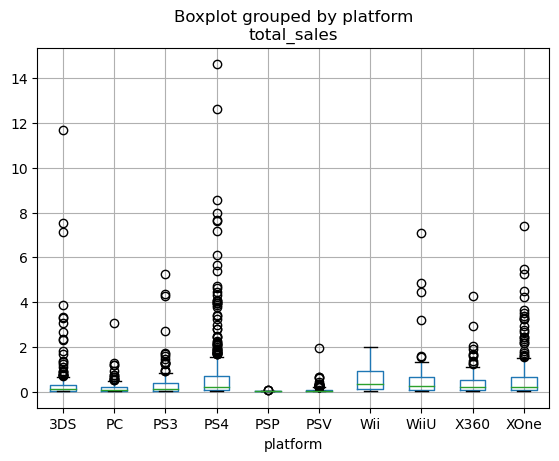

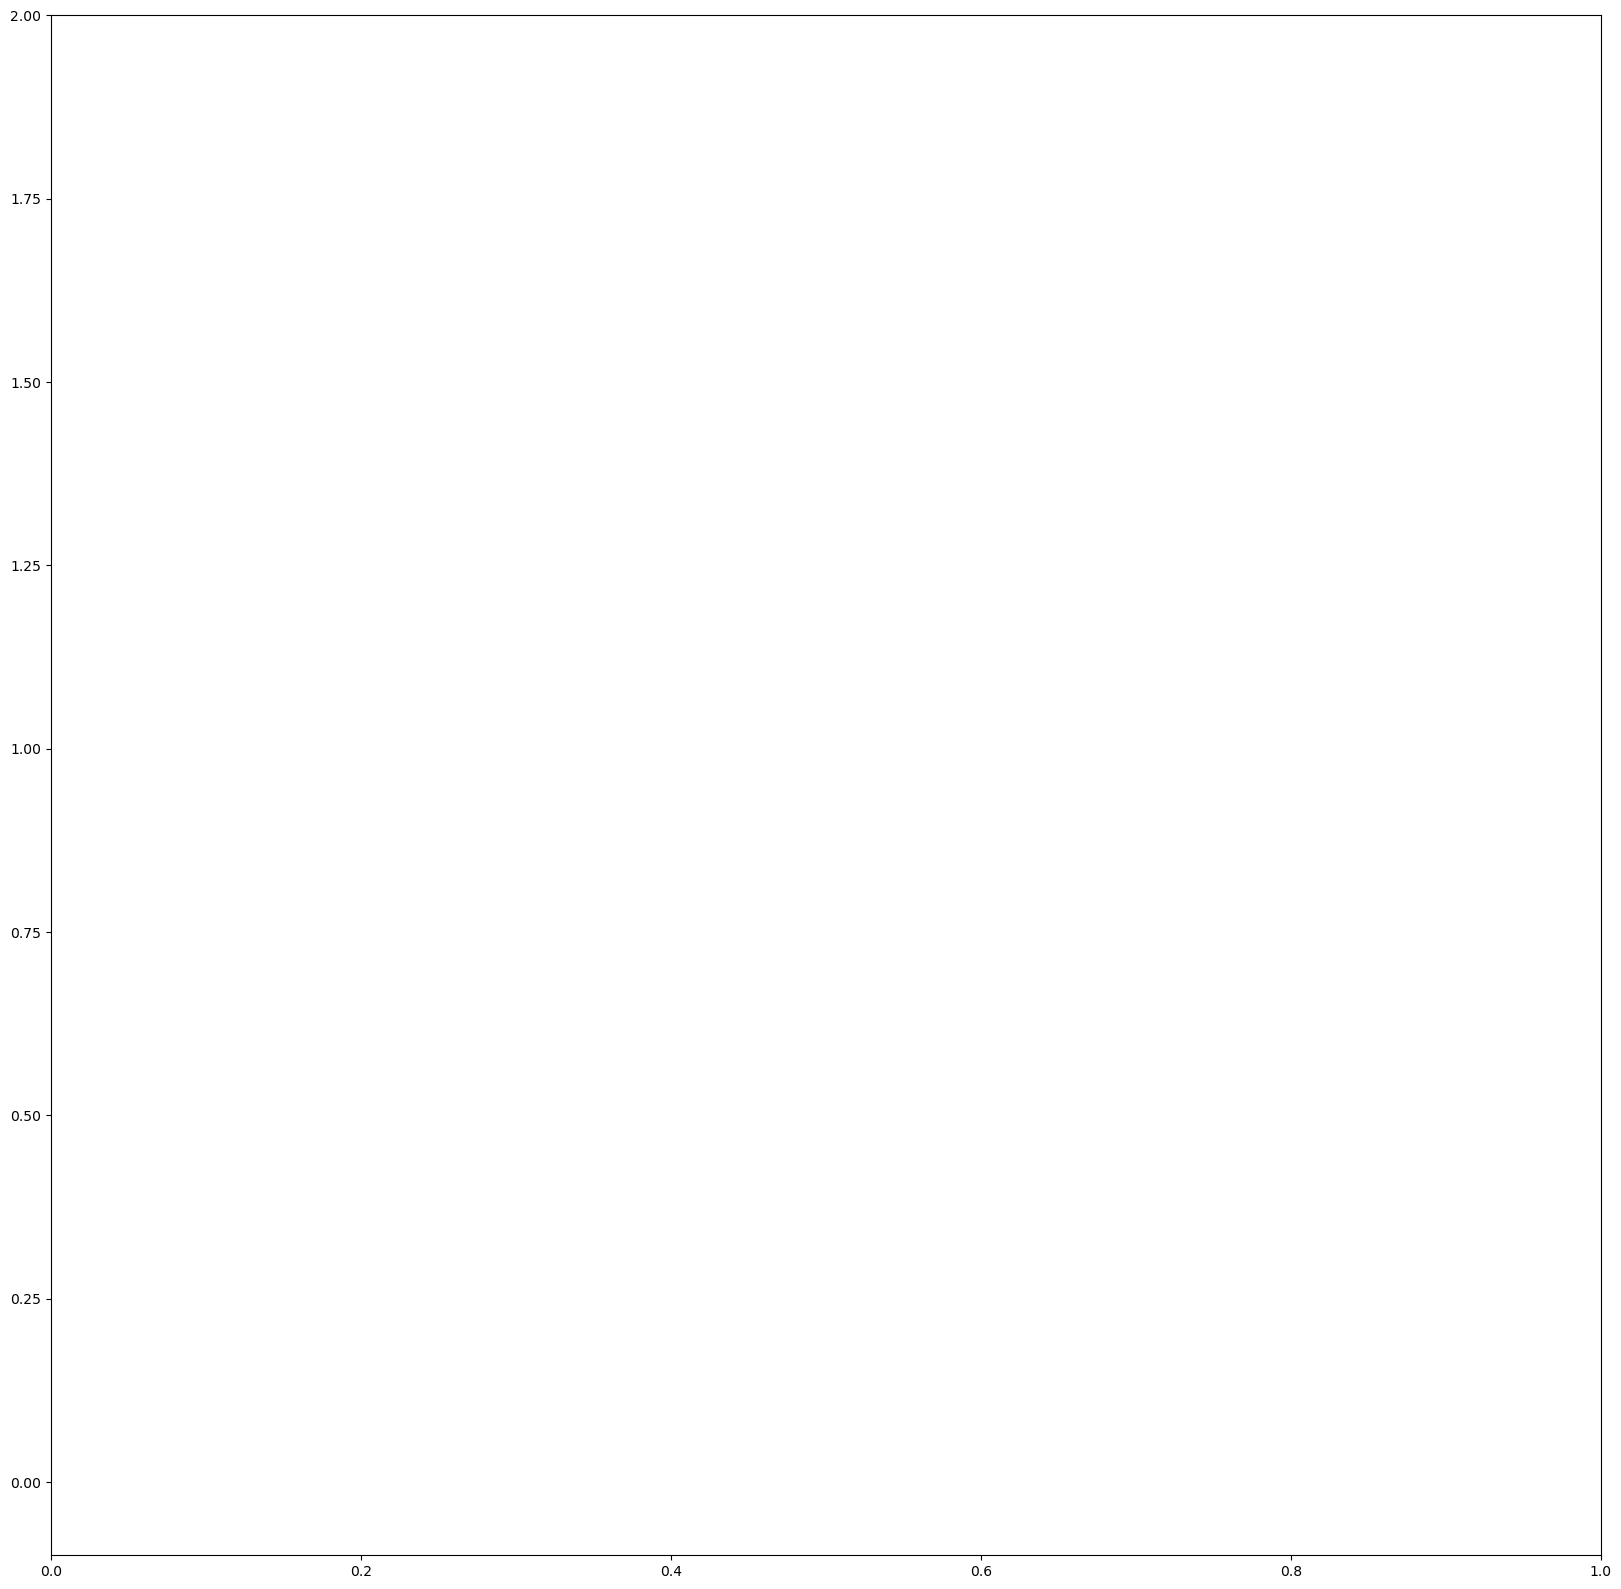

In [46]:
data_actual_top10.boxplot(by='platform', column='total_sales')
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))
plt.ylim(-0.1, 2)
#plt.xlim(0, 10)

Заметно деление на 2 группы среди платформ: лидеры и поспевающие.  
  
Рассмотрим группу поспевающих (все кроме PS3, PS4, X360, XOne).
* Межквартильный размах (50%) продаж игр на большинстве платформ находится в пределах от 0 млн. до 0.5 млн.
* Q3 (75% данных) не достигает 0.5 млн. копий.
* Максимальные значения не более 1.1 млн. копий. 

Рассмотрим группу лидеров (PS3, PS4, X360, XOne).
* Наиболее успешные платформы имеют межквартильный размах в пределах от 0 млн. до 0.75 млн. копий.
* Q3 (75% данных) находится близко к 0.75 млн. копий.
* Максимум около отметки в 1.75 млн. копий.  
  
Судя по многочисленным выбросам, у многих платформ есть десятки очень популярных игр, объемы продаж которых могут достигать более 10 млн. копий.

3.7 Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [47]:
ps4_data_actual = data_actual.query('platform == "PS4"')

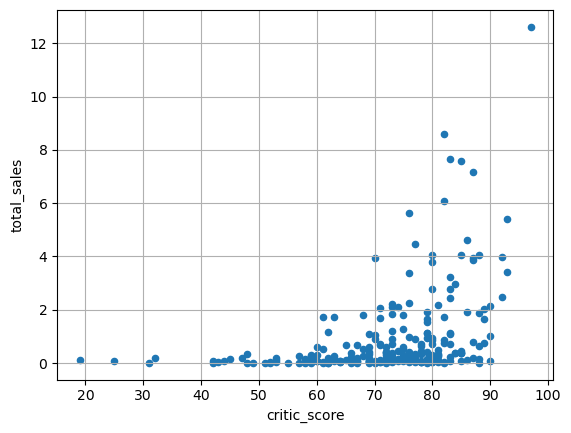

In [48]:
ps4_data_actual.plot(x='critic_score', y='total_sales', kind='scatter', grid=1);

In [49]:
print(ps4_data_actual['critic_score'].corr(ps4_data_actual['total_sales']))

0.40249779652369827


Оценки критиков имеют положительный эффект на продажи игр. Можно заметить, что отметку в 4 млн. копий преодолевают только игры оцененные критиками в 70 баллов и более.

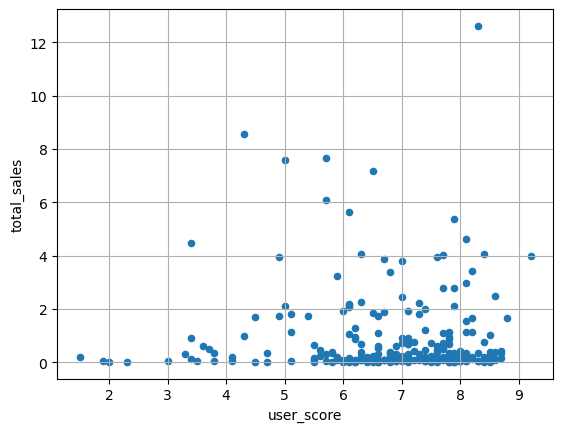

In [50]:
ps4_data_actual.plot(x='user_score', y='total_sales', kind='scatter', grid=1);

In [51]:
print(ps4_data_actual['user_score'].corr(ps4_data_actual['total_sales']))

-0.040131589472697356


Оценки игроков имеют незначительный отрицательный эффект на продажи игр, что довольно странно.

3.8 Соотнесите выводы с продажами игр на других платформах.

Посмотрим на влияние критиков на продажи

PS4: 0.40249779652369827
XOne: 0.42410142946275287
3DS: 0.28468579095782925
PS3: 0.44657460493190704
X360: 0.5257228356581523
WiiU: 0.3756402218389979
PC: 0.17463413769350036
PSV: 0.04102908974171329
Wii: nan
PSP: nan


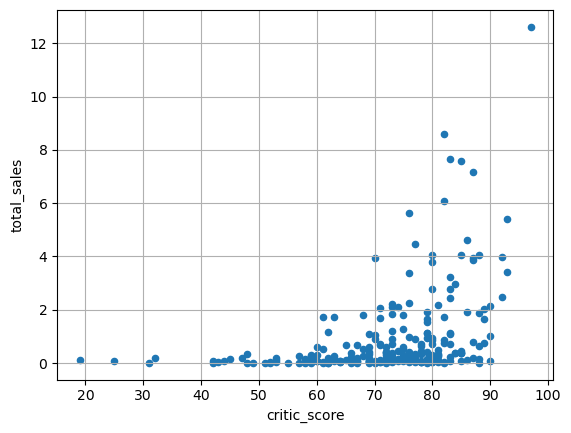

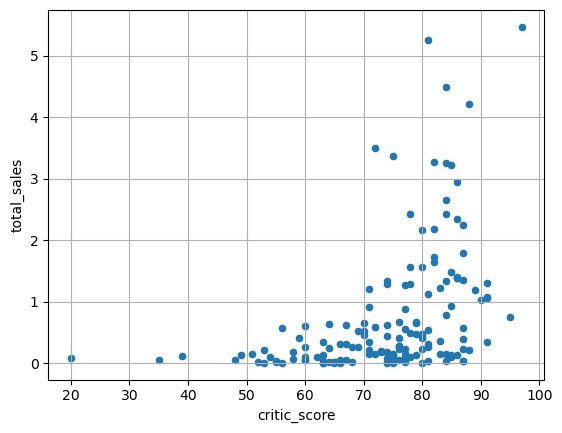

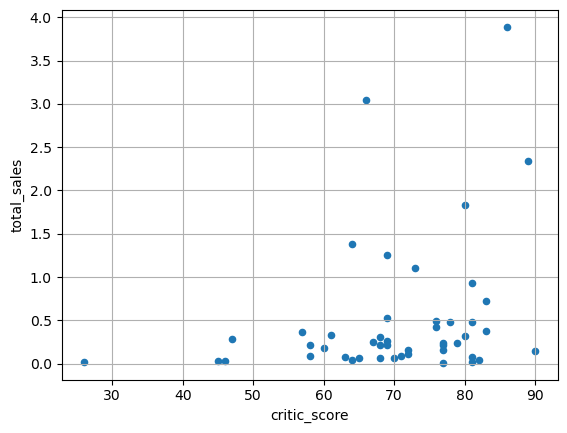

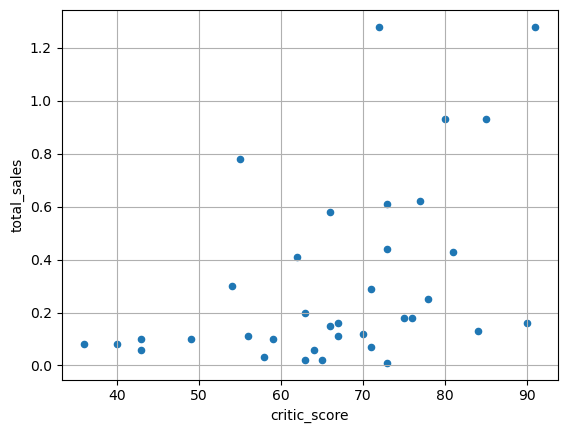

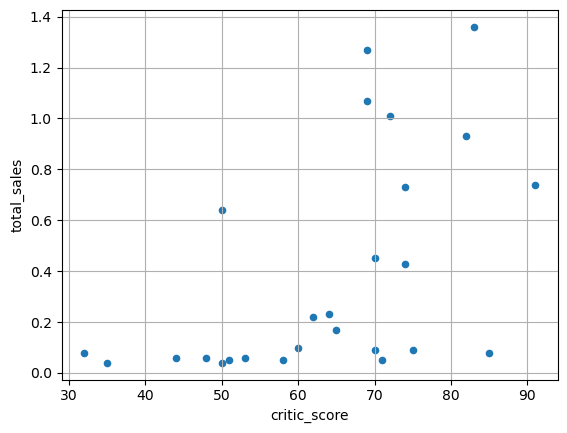

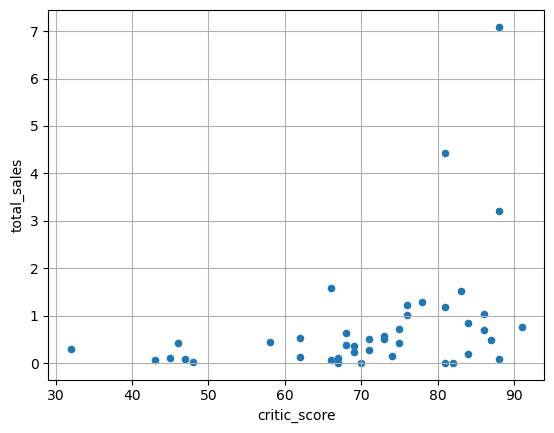

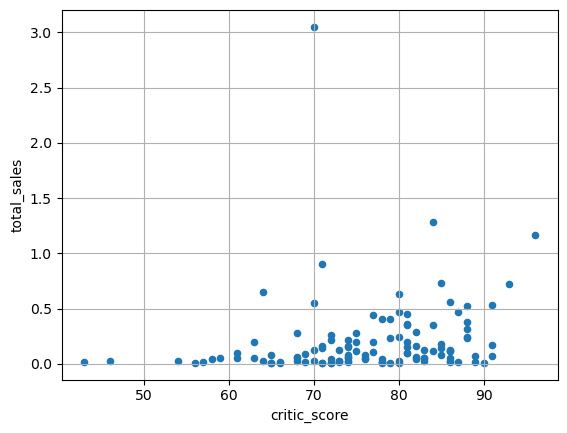

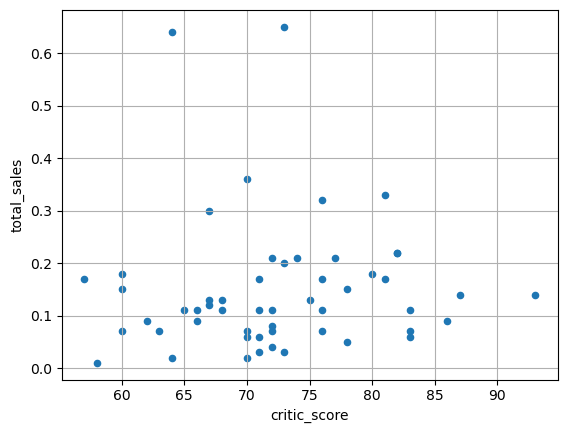

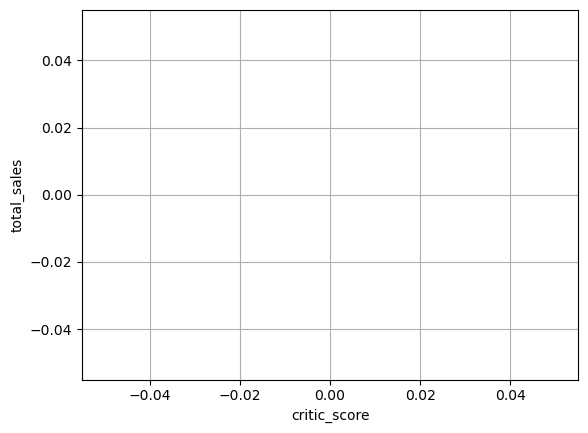

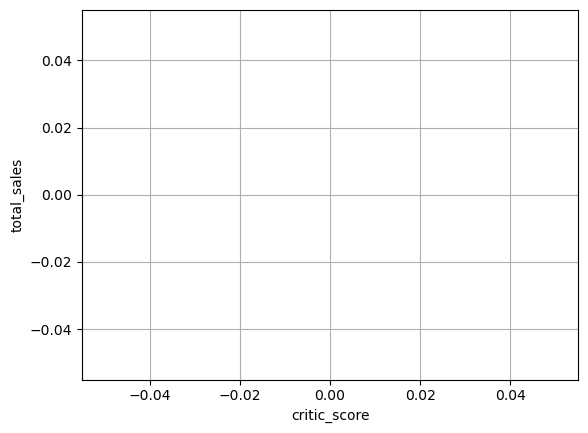

In [52]:
for plat in top_actual_platforms:
    platform_data_actual = data_actual.query('platform == @plat')
    platform_data_actual.plot(x='critic_score', y='total_sales', kind='scatter', grid=1);
    print(f'{plat}: {platform_data_actual["critic_score"].corr(platform_data_actual["total_sales"])}')

Посмотрим на влияние игроков на продажи

PS4: -0.040131589472697356
XOne: -0.0703839280647581
3DS: 0.2151932718527028
PS3: -0.16676141347662118
X360: -0.138444570945665
WiiU: 0.40792645792170773
PC: -0.07159665703472451
PSV: -0.16845504978064446
Wii: 1.0
PSP: nan


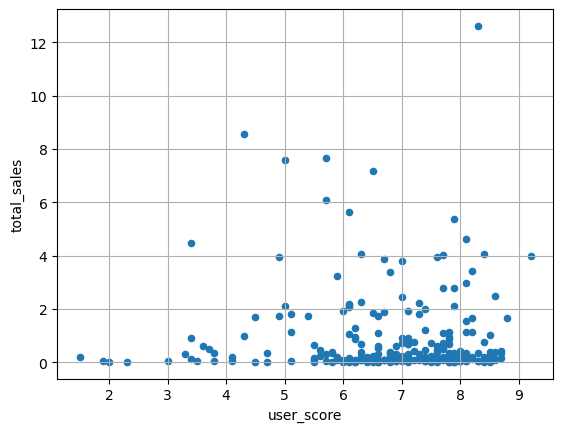

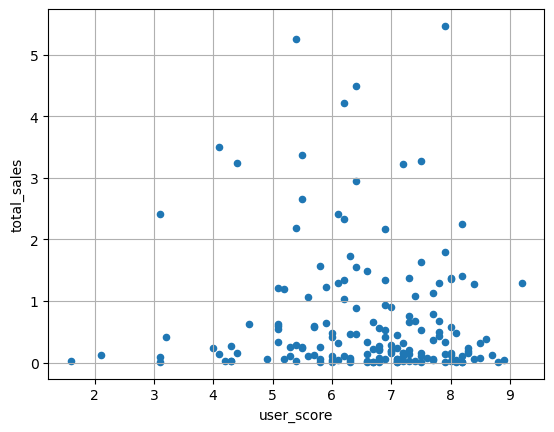

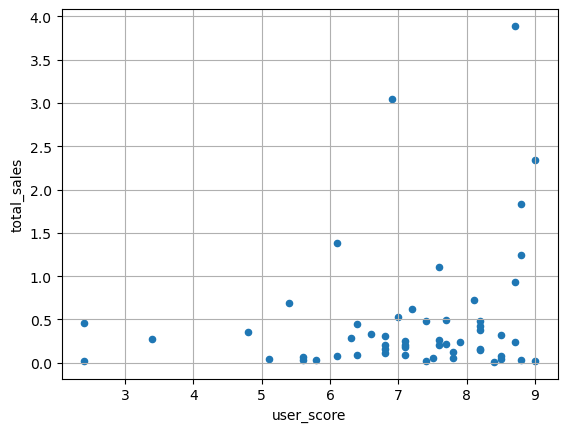

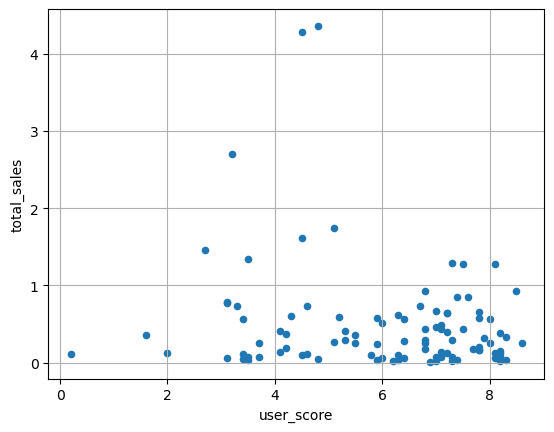

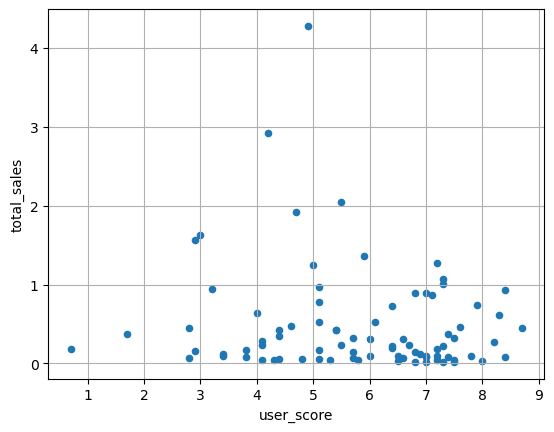

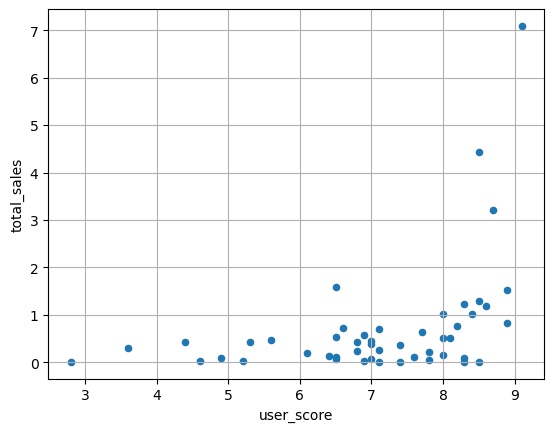

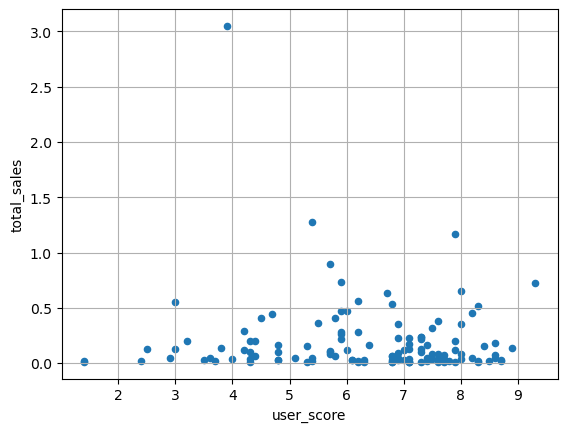

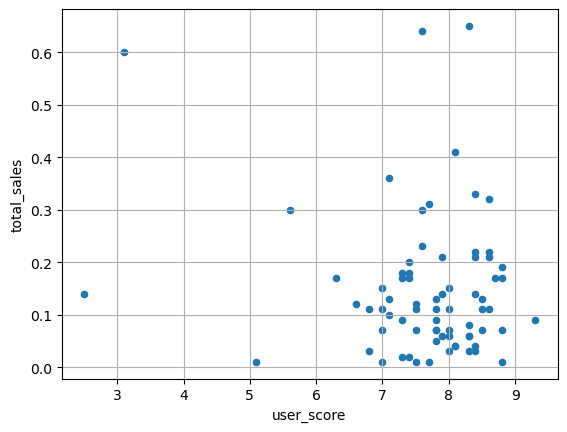

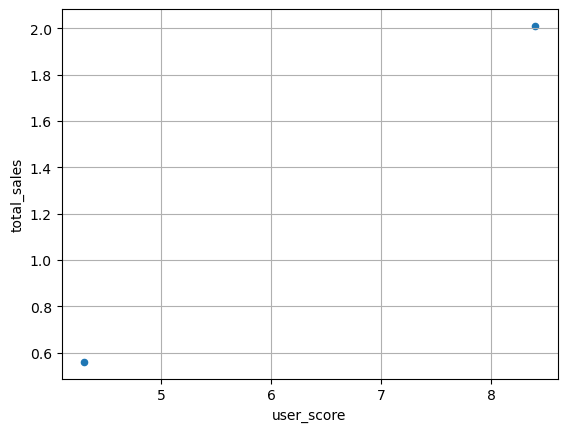

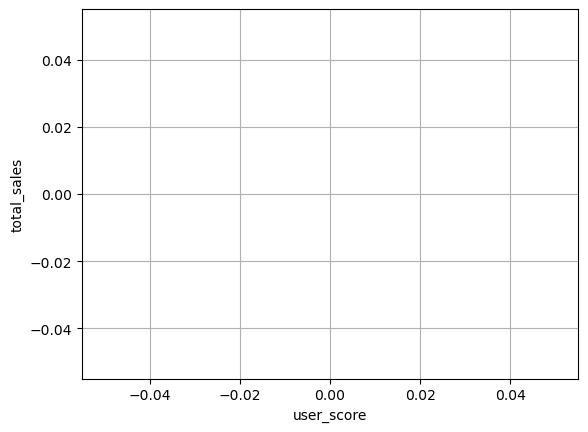

In [53]:
for plat in top_actual_platforms:
    platform_data_actual = data_actual.query('platform == @plat')
    platform_data_actual.plot(x='user_score', y='total_sales', kind='scatter', grid=1);
    print(f'{plat}: {platform_data_actual["user_score"].corr(platform_data_actual["total_sales"])}')

На всех платформах рейтинги критиков имеют достаточно сильное положительное влияние на продажи, в то время как оценки игроков влияют несильно позитивно или негативно.

3.9 Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [54]:
sales_by_genre = data_actual.pivot_table(index='genre', values='total_sales', aggfunc='median')

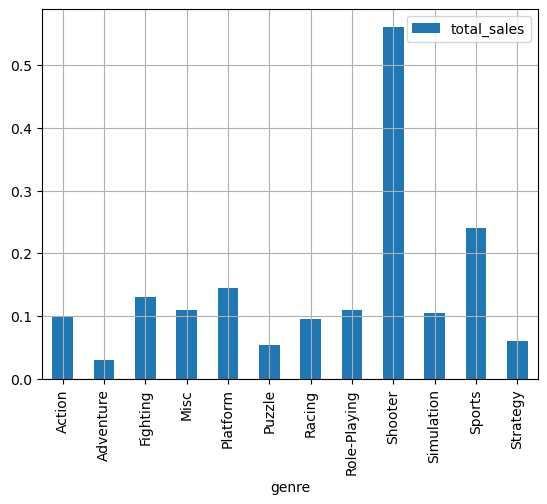

In [55]:
sales_by_genre.plot(kind = 'bar', grid=1);

Наиболее продаваемые жанры игр: Шутеры - очень прибыльный жанр, медианные продажи сильно выделяются на общем фоне. Следующие по прибыльности жанры - спортивные и платформеры.

**Шаг 4. Составьте портрет пользователя каждого региона**  
Определите для пользователя каждого региона (NA, EU, JP):

4.1 Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [56]:
data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(10)

,na_sales
platform,
PS4,98.49
XOne,80.92
X360,27.54
3DS,22.23
PS3,21.82
WiiU,19.16
PC,7.23
PSV,2.51
Wii,1.16


Американские геймеры отдают предпочтение PS4, XOne, X360, 3DS, PS3. Можно заметить, что персональный компьютер в америке не слишком популярная платформа для геймеров.

In [57]:
data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(10)

,eu_sales
platform,
PS4,130.04
XOne,46.09
PS3,24.97
PC,17.88
3DS,15.42
X360,15.01
WiiU,12.99
PSV,3.38
Wii,1.38


В ЕС рынок разделен похожим образом. Однако консоли Playstation более популярны чем XBox, а персональные компьютеры пользуются большим спросом у геймеров чем в США.

In [58]:
data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(10)

,jp_sales
platform,
3DS,44.13
PS4,15.02
PSV,14.43
PS3,10.85
WiiU,7.31
PSP,0.36
XOne,0.32
X360,0.08
PC,0.00


Совсем иначе разделен рынок японских игровых платформ. Японцы отдают предпочтение отчественным компактным портативным приставкам Nintendo. В лидерах Nintendo 3DS, затем PS4 и PSvita, PS3, WiiU. Интересно, что Xbox совсем не пользуются спросом в сравнении с западными странами.

4.2 Самые популярные жанры (топ-5). Поясните разницу.

In [59]:
data_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)

,na_sales
genre,
Shooter,78.89
Action,71.17
Sports,46.03
Role-Playing,33.47
Misc,14.31


Америкацы любят стрелялки, экшн, спортивные игры. Ничего примечательного.

In [60]:
data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)

,eu_sales
genre,
Action,73.15
Shooter,65.44
Sports,45.48
Role-Playing,28.17
Racing,14.03


Европейцы имеют схожие с американскими собратьями вкусы, экшн популярнее шутеров.

In [61]:
data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)

,jp_sales
genre,
Role-Playing,31.16
Action,29.11
Fighting,6.34
Misc,5.61
Shooter,4.87


Японцы, предпочитают ролевые игры экшн-играм и шутерам. Так же популярны жанры: драки, misc. Шутеры на последнем месте.

4.3 Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [62]:
data_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)

,na_sales
rating,
M,96.36
Unknown,64.68
E,50.25
T,38.76
E10+,31.01


In [63]:
data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)

,eu_sales
rating,
M,93.42
Unknown,58.74
E,57.44
T,33.93
E10+,23.63


В америке и европе влияние рейтинга на продажи схожее. Наиболее популярны игры с рейтингом M, Unknown, E, T.

In [64]:
data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)

,jp_sales
rating,
Unknown,56.90
T,14.32
E,8.94
M,8.01
E10+,4.33


Интересно, что в японии на первом месте стоит жанр Unknown. Игры без рейтинга, возможно, являются играми для местного рынка.

Вывод: предпочтения игроков сильно различаются в зависимости от региона.

**Шаг 5. Проверьте гипотезы**

5.1 Проверим гипотезу:  
H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
H1: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [65]:
data_actual_xone = data_actual.query('platform == "XOne"').dropna()
data_actual_pc = data_actual.query('platform == "PC"').dropna()

In [66]:
array1 = list(data_actual_xone['user_score'])
array2 = list(data_actual_pc['user_score'])

results = st.ttest_ind(array1, array2, equal_var=False)

print(sum(array1)/len(array1))
print(sum(array2)/len(array2))

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

6.620529801324504
6.341739130434782
p-значение: 0.1403785186826978
Не получилось отвергнуть нулевую гипотезу


Средний пользовательский рейтинг на платформах XOne и PC одинаковый (примерно 6.6)

5.2 Проверим гипотезу:  
H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.  
H1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [67]:
data_actual_action = data_actual.query('genre == "Action"').dropna()
data_actual_sports = data_actual.query('genre == "Sports"').dropna()

In [68]:
s1 = list(data_actual_action['user_score'])
s2 = list(data_actual_sports['user_score'])

results = st.ttest_ind(s1, s2, equal_var=False)

print(sum(s1)/len(s1))
print(sum(s2)/len(s2))

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

6.832599118942724
5.684337349397592
p-значение: 8.327612976032047e-09
Отвергаем нулевую гипотезу


Средние оценки игроков в жанрах Экшн и Спорт отличаются.

5.2.1 Как вы сформулировали нулевую и альтернативную гипотезы:  
* Нулевая гипотеза всегда проверяет равенство сравниваемых параметров. Альтернативная - двусторонняя, так как оценки могут отличаться в большую и в меньшую сторону.

5.2.2 Какой критерий применили для проверки гипотез и почему:  
* Мы применили двусторонний тест Стьюдента с p-value = 5% (95% уровнем доверия). Использовался вариант теста подходящий для двух разных выборок, размеры которых отличаются и/или есть основания полагать, что значения дисперсии различаются. В первом тесте выборки разных размеров представляют два разных сегмента покупателей (разные платформы), во втором тесте помимо того, что размеры выборок разные, есть основания пологать, что в разные жанры игр играют разные сегменты игроков (пол, возраст, доход).


Вывод: Средний пользовательский рейтинг на платформах XOne и PC одинаковый (примерно 6.6). Средние оценки игроков в жанрах Экшн и Спорт отличаются.

**Шаг 6. Напишите общий вывод**  

**Ситуация в индустрии игровых платформ:**
* Игровая индустрия начала свой расцет после 90-х и дошла до пика в 2008-2009 годах. После финансового кризиса 2008-2009 игровая индустрия пошла на спад.
* Примерно каждые 10 лет появляется новая версия игровой платформы, а старая приходит в упадок.
* Наиболее популярные платформы в мире на момент 2016 года - это PS3, X360, Wii, DS, PS4, 3DS, PSP, PC, XOne, PS2
* Во всем мире наиболее продаваемые жанры игр: Экшн, Шутеры, Спортивные, Misc(без определенного жанра), Ролевые.

**Деление на группы среди платформ:**  
  
Рассмотрим группу поспевающих (все кроме PS3, PS4, X360, XOne).
* 75% игр не достигает отметки в 0.5 млн. проданных копий.
* Максимальные значения продаж одной игры не более 1.1 млн. копий. 

Рассмотрим группу лидеров (PS3, PS4, X360, XOne).
* 75% игр близко к отметке 0.75 млн. проданных копий.
* Максимальные значения продаж одной игры около 1.75 млн. проданных копий.   
  
Стоит заметить, что у многих платформ есть десятки очень популярных игр, объемы продаж которых могут достигать более 10 млн. копий.

**Влияние оценок и рейтингов:**  
* Оценки критиков имеют положительный эффект на продажи игр. Можно заметить, что отметку в 4 млн. копий преодолевают только игры оцененные критиками в 70 баллов и более.
* Оценки игроков имеют незначительный отрицательный эффект на продажи игр, что довольно странно.
* В америке и европе влияние рейтинга на продажи почти одинаковое. Наиболее популярны игры с рейтингом M, E, T.
* Интересно, что в японии наиболее популярны жанры Unknown, E, T. Игры без рейтинга, возможно, являются играми для местного рынка.


**Платформы. Отличия в предпочтениях геймеров из США, Европы и Японии:**
* Американские геймеры отдают предпочтение Хbox 360, PS3 и Wii. Новые платформы, такие как PS4 и Xbox one, Nintendo 3ds, пока не успели превзойти своих предшественников в объеме продаж. Можно заметить, что персональный компьютер в америке не слишком популярная платформа для геймеров.
* В ЕС рынок разделен похожим образом. Однако консоли Playstation более популярны чем XBox, а персональные компьютеры пользуются большим спросом у геймеров чем в США.
* Совсем иначе разделенн рынок японских игровых платформ. Японцы отдают предпочтение отчественным компактным портативным приставкам Nintendo. В лидерах Nintendp DS и 3DS, затем PS3 и PSP, Wii. Интересно, что Xbox 360 находится на 10 месте.

**Жанры. Отличия в предпочтениях геймеров из США, Европы и Японии:**
* Топ 5 америки: экшн, шутеры, спортивные игры, misc (без определенного жанра), ролевые.
* Топ 5 европы: экшн, шутеры, спортивные игры, misc (без определенного жанра), гонки.
* Топ 5 японии: ролевые, экшн, misc, спортивные игры, приключения. Японцы, предпочитают ролевые игры экшн-играм в силу национальной специфики (игры аниме жанра). Так же, показательно наличие жанра Misc в топ 3, потому что японцам нравятся странные игры. Интересно, что шутеры не попали в топ 5. 

**Статистические тесты:**
* Мы выснили, что средние оценки игроков не сильно зависят от платформы (в случае с PC и XOne), но зависят от жанра игры (в случае с Action и Sports играми). Для экстраполяции этих выводов на другие платформы и жанры необходимо проводить дополнительные исследования.